2025-12-04 14:09:19.013978: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 14:09:19.252334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 14:09:20.349639: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU e Mixed Precision Attivate.
Caricamento Modello LSTM...


I0000 00:00:1764853763.440753    5518 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4130 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Modello Caricato.
Caricamento 15000 batch di dati puliti...
Dati caricati: (960000, 30, 4)
Iniezione Attacchi
Esecuzione Predizioni LSTM:
    1/15000 ━━━━━━━━━━━━━━━━━━━━ 1:34:18 377ms/step

2025-12-04 14:09:27.491313: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-12-04 14:09:27.519639: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step

Soglia Calcolata (Mean+3Std su Normali): 0.027605

REPORT LSTM (N=960000)
              precision    recall  f1-score   support

      Normal       0.71      0.98      0.82    192000
      Attack       1.00      0.90      0.94    768000

    accuracy                           0.92    960000
   macro avg       0.85      0.94      0.88    960000
weighted avg       0.94      0.92      0.92    960000

--------------------------------------------------
SCENARIO             | RILEVATI            | RATE      
--------------------------------------------------
1. Speed Spoofing    | 192000   / 192000   | 100.00%
2. Teleport          | 192000   / 192000   | 100.00%
3. Ghost Ship        | 114109   / 192000   | 59.43%
4. Silent Drift      | 192000   / 192000   | 100.00%
--------------------------------------------------
*. Normali (FP)      | 2962     / 192000   | 1.54%
--------------------------------------------------


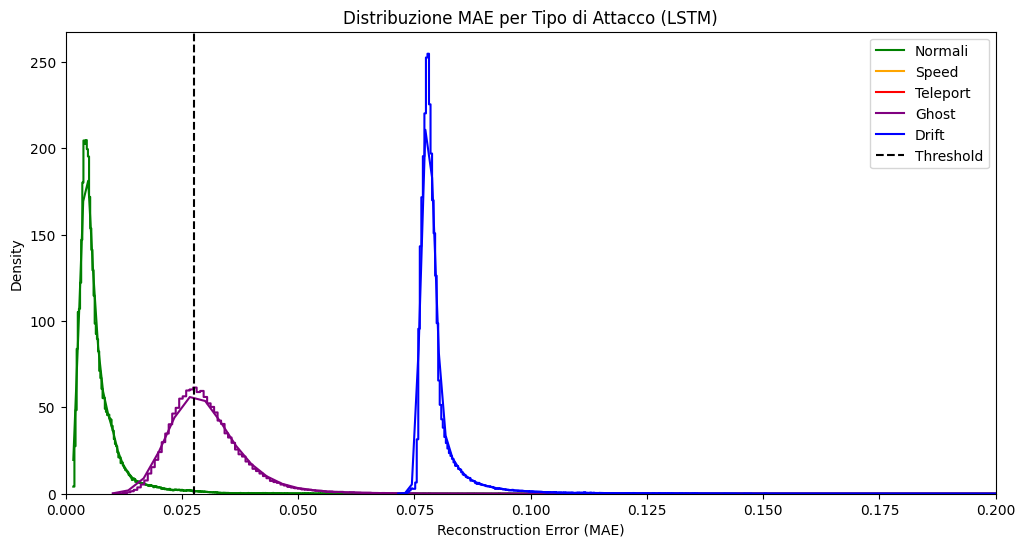

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import gc

from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras import mixed_precision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("GPU e Mixed Precision Attivate.")
    except RuntimeError: pass

WINDOW_SIZE = 30
BATCH_SIZE = 64
COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL'
SCALER_PATH = 'scaler.joblib'
MODEL_PATH = 'lstm_autoencoder_best.keras'

def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue

def inject_attacks(X_clean):
    n_samples = len(X_clean)
    n_cats = 5 
    split_size = n_samples // n_cats
    
    X_mixed = X_clean.copy()
    y_true = np.zeros(n_samples)
    attack_type = np.zeros(n_samples)

    idx_norm = range(0, split_size)
    idx_speed = range(split_size, 2*split_size)
    idx_tele = range(2*split_size, 3*split_size)
    idx_ghost = range(3*split_size, 4*split_size)
    idx_drift = range(4*split_size, n_samples)

    noise_speed = np.random.normal(5.0, 2.0, X_mixed[idx_speed, :, 2].shape) 
    X_mixed[idx_speed, :, 2] += noise_speed
    y_true[idx_speed] = 1
    attack_type[idx_speed] = 1

    X_mixed[idx_tele, -5:, 0] += 0.5 
    X_mixed[idx_tele, -5:, 1] += 0.5
    y_true[idx_tele] = 1
    attack_type[idx_tele] = 2

    X_mixed[idx_ghost, :, 3] = (X_mixed[idx_ghost, :, 3] + 0.5) % 1.0 
    X_mixed[idx_ghost, :, 3] += np.random.normal(0, 0.2, X_mixed[idx_ghost, :, 3].shape)
    y_true[idx_ghost] = 1
    attack_type[idx_ghost] = 3

    drift_rate = 0.01
    steps = np.arange(WINDOW_SIZE)
    drift_vector = steps * drift_rate
    X_mixed[idx_drift, :, 0] += drift_vector 
    X_mixed[idx_drift, :, 1] += drift_vector
    y_true[idx_drift] = 1
    attack_type[idx_drift] = 4
    
    return X_mixed, y_true, attack_type, idx_norm, idx_speed, idx_tele, idx_ghost, idx_drift

if not os.path.exists(SCALER_PATH) or not os.path.exists(MODEL_PATH):
    print("ERRORE: Scaler o Modello non trovati.")
else:
    scaler = joblib.load(SCALER_PATH)
    all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
    TEST_FILES = all_files[20:24]

    print("Caricamento Modello LSTM...")
    model = load_model(MODEL_PATH)
    print("Modello Caricato.")

    NUM_BATCHES_TEST = 15000 
    X_list = []

    print(f"Caricamento {NUM_BATCHES_TEST} batch di dati puliti...")
    test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)

    try:
        for _ in range(NUM_BATCHES_TEST):
            b, _ = next(test_gen)
            X_list.append(b)
        X_clean_total = np.concatenate(X_list, axis=0)
    except StopIteration:
        print("Generatore terminato prima del previsto.")
        X_clean_total = np.concatenate(X_list, axis=0)

    print(f"Dati caricati: {X_clean_total.shape}")

    print("Iniezione Attacchi")
    X_test, y_true, attack_types, idx_norm, idx_speed, idx_tele, idx_ghost, idx_drift = inject_attacks(X_clean_total)

    print("Esecuzione Predizioni LSTM:")
    reconstructions = model.predict(X_test, verbose=1, batch_size=BATCH_SIZE)

    mae_loss = np.mean(np.abs(X_test - reconstructions), axis=(1, 2))

    mae_normal = mae_loss[idx_norm]
    THRESHOLD = np.mean(mae_normal) + 3 * np.std(mae_normal)

    print(f"\nSoglia Calcolata (Mean+3Std su Normali): {THRESHOLD:.6f}")

    y_pred = (mae_loss > THRESHOLD).astype(int)

    print("\n" + "="*60)
    print(f"REPORT LSTM (N={len(y_pred)})")
    print("="*60)

    print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

    def print_result(name, idxs):
        total = len(idxs)
        caught = np.sum(y_pred[idxs])
        rate = (caught / total) * 100
        print(f"{name:<20} | {caught:<8} / {total:<8} | {rate:.2f}%")

    print("-" * 50)
    print(f"{'SCENARIO':<20} | {'RILEVATI':<19} | {'RATE':<10}")
    print("-" * 50)
    print_result("1. Speed Spoofing", idx_speed)
    print_result("2. Teleport", idx_tele)
    print_result("3. Ghost Ship", idx_ghost)
    print_result("4. Silent Drift", idx_drift)
    print("-" * 50)
    print_result("*. Normali (FP)", idx_norm)
    print("-" * 50)

    plt.figure(figsize=(12, 6))
    sns.histplot(mae_normal, color='green', label='Normali', kde=True, stat="density", element="step", fill=False)
    sns.histplot(mae_loss[idx_speed], color='orange', label='Speed', kde=True, stat="density", element="step", fill=False)
    sns.histplot(mae_loss[idx_tele], color='red', label='Teleport', kde=True, stat="density", element="step", fill=False)
    sns.histplot(mae_loss[idx_ghost], color='purple', label='Ghost', kde=True, stat="density", element="step", fill=False)
    sns.histplot(mae_loss[idx_drift], color='blue', label='Drift', kde=True, stat="density", element="step", fill=False)

    plt.axvline(THRESHOLD, color='k', linestyle='--', label='Threshold')
    plt.title("Distribuzione MAE per Tipo di Attacco (LSTM)")
    plt.xlabel("Reconstruction Error (MAE)")
    plt.legend()
    plt.xlim(0, 0.2) 
    plt.show()

AVVIO STRESS TEST PARAMETRICO COMPLETO (Soglia: 0.027605)
Base dati: 64 campioni puliti.

1. Esecuzione Test Teleport (Salto Posizionale)
   -> Salto 0.0010: Rilevato 6.2%
   -> Salto 0.0050: Rilevato 6.2%
   -> Salto 0.0100: Rilevato 6.2%
   -> Salto 0.0200: Rilevato 6.2%
   -> Salto 0.0500: Rilevato 100.0%
   -> Salto 0.0600: Rilevato 100.0%
   -> Salto 0.0700: Rilevato 100.0%
   -> Salto 0.0800: Rilevato 100.0%
   -> Salto 0.0900: Rilevato 100.0%
   -> Salto 0.1000: Rilevato 100.0%
   -> Salto 0.2000: Rilevato 100.0%
   -> Salto 0.5000: Rilevato 100.0%

2. Esecuzione Test Speed Spoofing (Intensità Rumore)
   -> Rumore 0.1: Rilevato 32.8%
   -> Rumore 0.2: Rilevato 96.9%
   -> Rumore 0.3: Rilevato 100.0%
   -> Rumore 0.4: Rilevato 100.0%
   -> Rumore 0.5: Rilevato 100.0%
   -> Rumore 1.0: Rilevato 100.0%
   -> Rumore 2.0: Rilevato 100.0%
   -> Rumore 5.0: Rilevato 100.0%
   -> Rumore 10.0: Rilevato 100.0%

3. Esecuzione Test Silent Drift (Lenta Deriva)
   -> Rateo 0.0001: Rilevato 6.

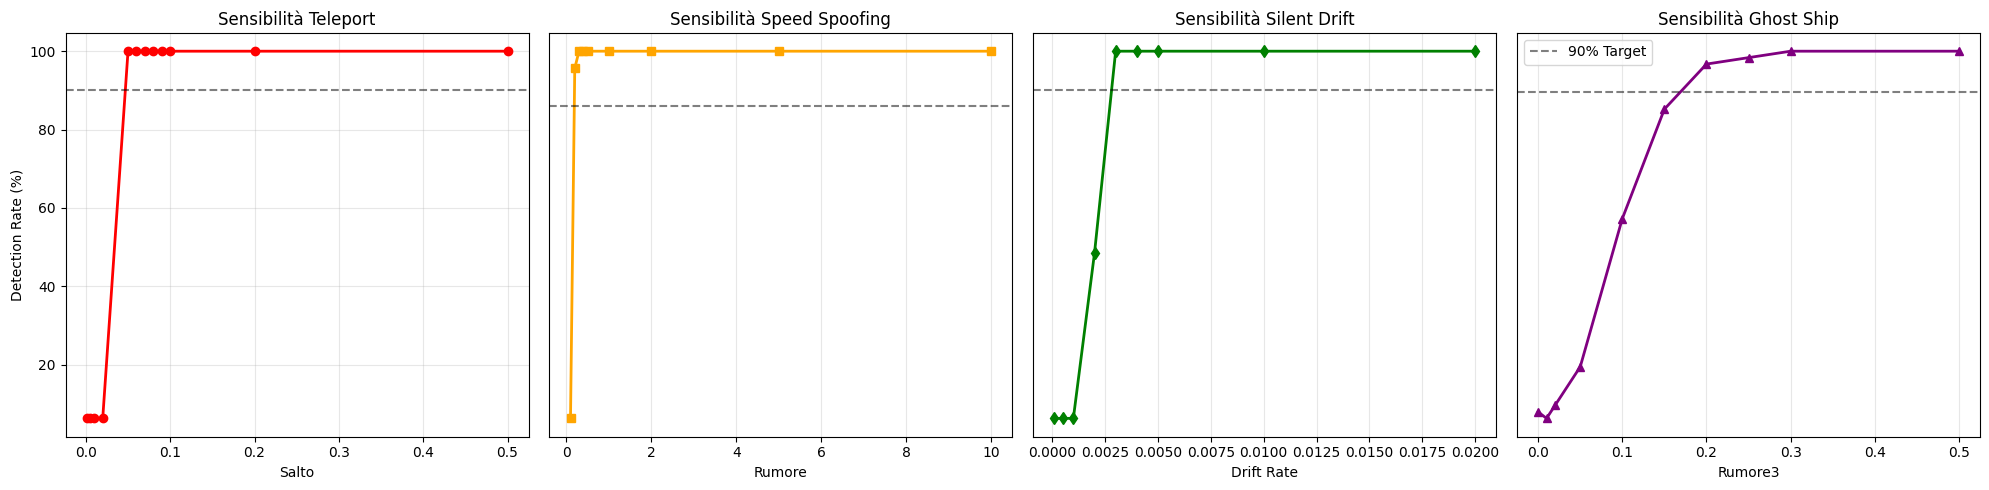

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurazione Soglia Finale
FINAL_THRESHOLD = 0.027605

print(f"AVVIO STRESS TEST PARAMETRICO COMPLETO (Soglia: {FINAL_THRESHOLD})")

# Funzione Helper per calcolare il Detection Rate su un batch
def get_detection_rate(X_attacked, model, threshold):
    preds = model.predict(X_attacked, verbose=0, batch_size=512)
    mae = np.mean(np.abs(X_attacked - preds), axis=(1, 2))
    # Quanti superano la soglia?
    rate = np.sum(mae > threshold) / len(mae)
    return rate * 100.0

# Carichiamo un batch di dati puliti da usare come base
try:
    X_base, _ = next(test_gen)
    # Ne prendiamo 20000 per avere statistica solida
    X_base = X_base[:20000]
except:
    test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE)
    X_base, _ = next(test_gen)
    X_base = X_base[:20000]

print(f"Base dati: {len(X_base)} campioni puliti.")


# TEST 1: TELEPORT SENSITIVITY (Minimum Jump Distance)
print("\n1. Esecuzione Test Teleport (Salto Posizionale)")
jump_values = [0.001, 0.005, 0.01, 0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5]
teleport_rates = []

for j in jump_values:
    X_temp = X_base.copy()
    X_temp[:, -5:, 0] += j # Lat
    X_temp[:, -5:, 1] += j # Lon
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    teleport_rates.append(rate)
    print(f"   -> Salto {j:.4f}: Rilevato {rate:.1f}%")


# TEST 2: SPEED SPOOFING SENSITIVITY (Noise Intensity)
print("\n2. Esecuzione Test Speed Spoofing (Intensità Rumore)")
noise_std_values = [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5.0, 10.0]
speed_rates = []

for n in noise_std_values:
    X_temp = X_base.copy()
    noise = np.random.normal(0, n, X_temp[:, :, 2].shape)
    X_temp[:, :, 2] += noise
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    speed_rates.append(rate)
    print(f"   -> Rumore {n:.1f}: Rilevato {rate:.1f}%")


# TEST 3: SILENT DRIFT SENSITIVITY (Drift Rate) 
print("\n3. Esecuzione Test Silent Drift (Lenta Deriva)")
drift_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02]
drift_rates = []
steps = np.arange(WINDOW_SIZE)

for d in drift_values:
    X_temp = X_base.copy()
    drift_vec = steps * d
    X_temp[:, :, 0] += drift_vec
    X_temp[:, :, 1] += drift_vec
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    drift_rates.append(rate)
    print(f"   -> Rateo {d:.4f}: Rilevato {rate:.1f}%")


# TEST 4: GHOST SHIP SENSITIVITY (Jitter Intensity)
# Qui variamo quanto è "rumorosa" l'inversione di rotta.
print("\n4. Esecuzione Test Ghost Ship (Intensità Jitter su COG)")
jitter_values = [0.0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]
ghost_rates = []

for j in jitter_values:
    X_temp = X_base.copy()
    # Inversione Rotta (180 gradi)
    X_temp[:, :, 3] = (X_temp[:, :, 3] + 0.5) % 1.0
    # Aggiunta Jitter Variabile
    jitter_noise = np.random.normal(0, j, X_temp[:, :, 3].shape)
    X_temp[:, :, 3] += jitter_noise
    
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    ghost_rates.append(rate)
    print(f"Jitter {j:.2f}: Rilevato {rate:.1f}%")


# Risultati Grafici
plt.figure(figsize=(20, 5))

# 1. Teleport
plt.subplot(1, 4, 1)
plt.plot(jump_values, teleport_rates, 'o-', color='red', linewidth=2)
plt.title("Sensibilità Teleport")
plt.xlabel("Salto")
plt.ylabel("Detection Rate (%)")
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5)

# 2. Speed
plt.subplot(1, 4, 2)
plt.plot(noise_std_values, speed_rates, 's-', color='orange', linewidth=2)
plt.title("Sensibilità Speed Spoofing")
plt.xlabel("Rumore")
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5)

# 3. Drift
plt.subplot(1, 4, 3)
plt.plot(drift_values, drift_rates, 'd-', color='green', linewidth=2)
plt.title("Sensibilità Silent Drift")
plt.xlabel("Drift Rate")
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5)

# 4. Ghost Ship
plt.subplot(1, 4, 4)
plt.plot(jitter_values, ghost_rates, '^-', color='purple', linewidth=2)
plt.title("Sensibilità Ghost Ship")
plt.xlabel("Rumore3")
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5, label='90% Target')
plt.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_5518/1222516853.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  detection_stats = df_res.groupby('Scenario').apply(lambda x: (x['Predicted'] == 1).sum() / len(x) * 100).reset_index(name='Detection_Rate')


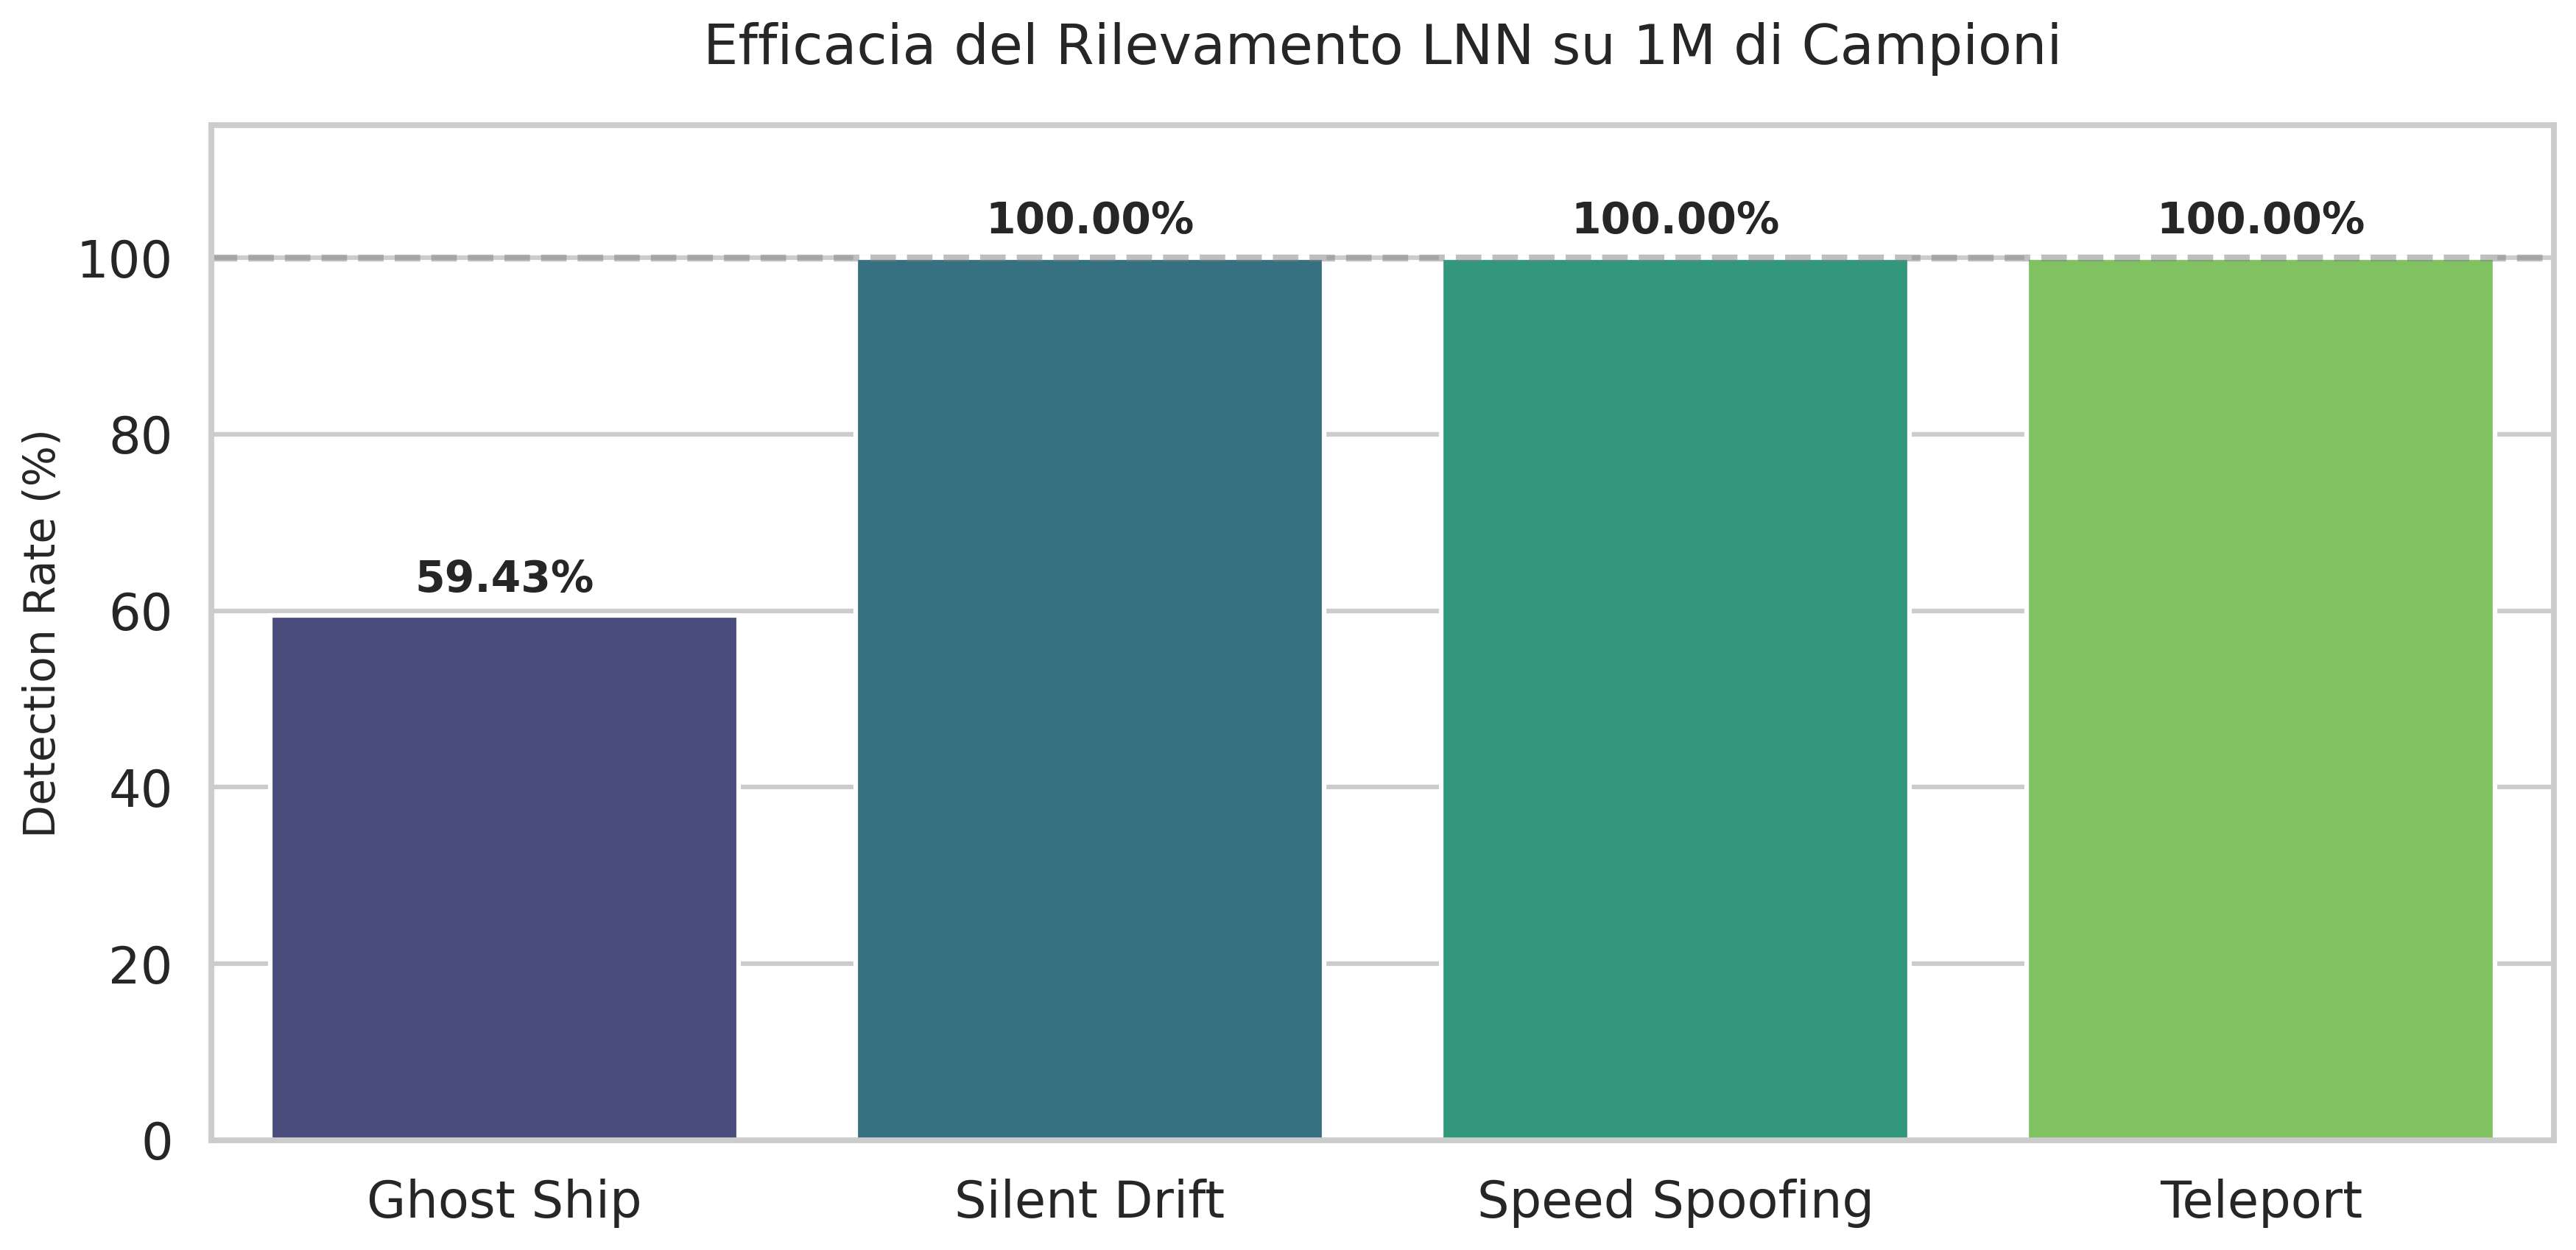

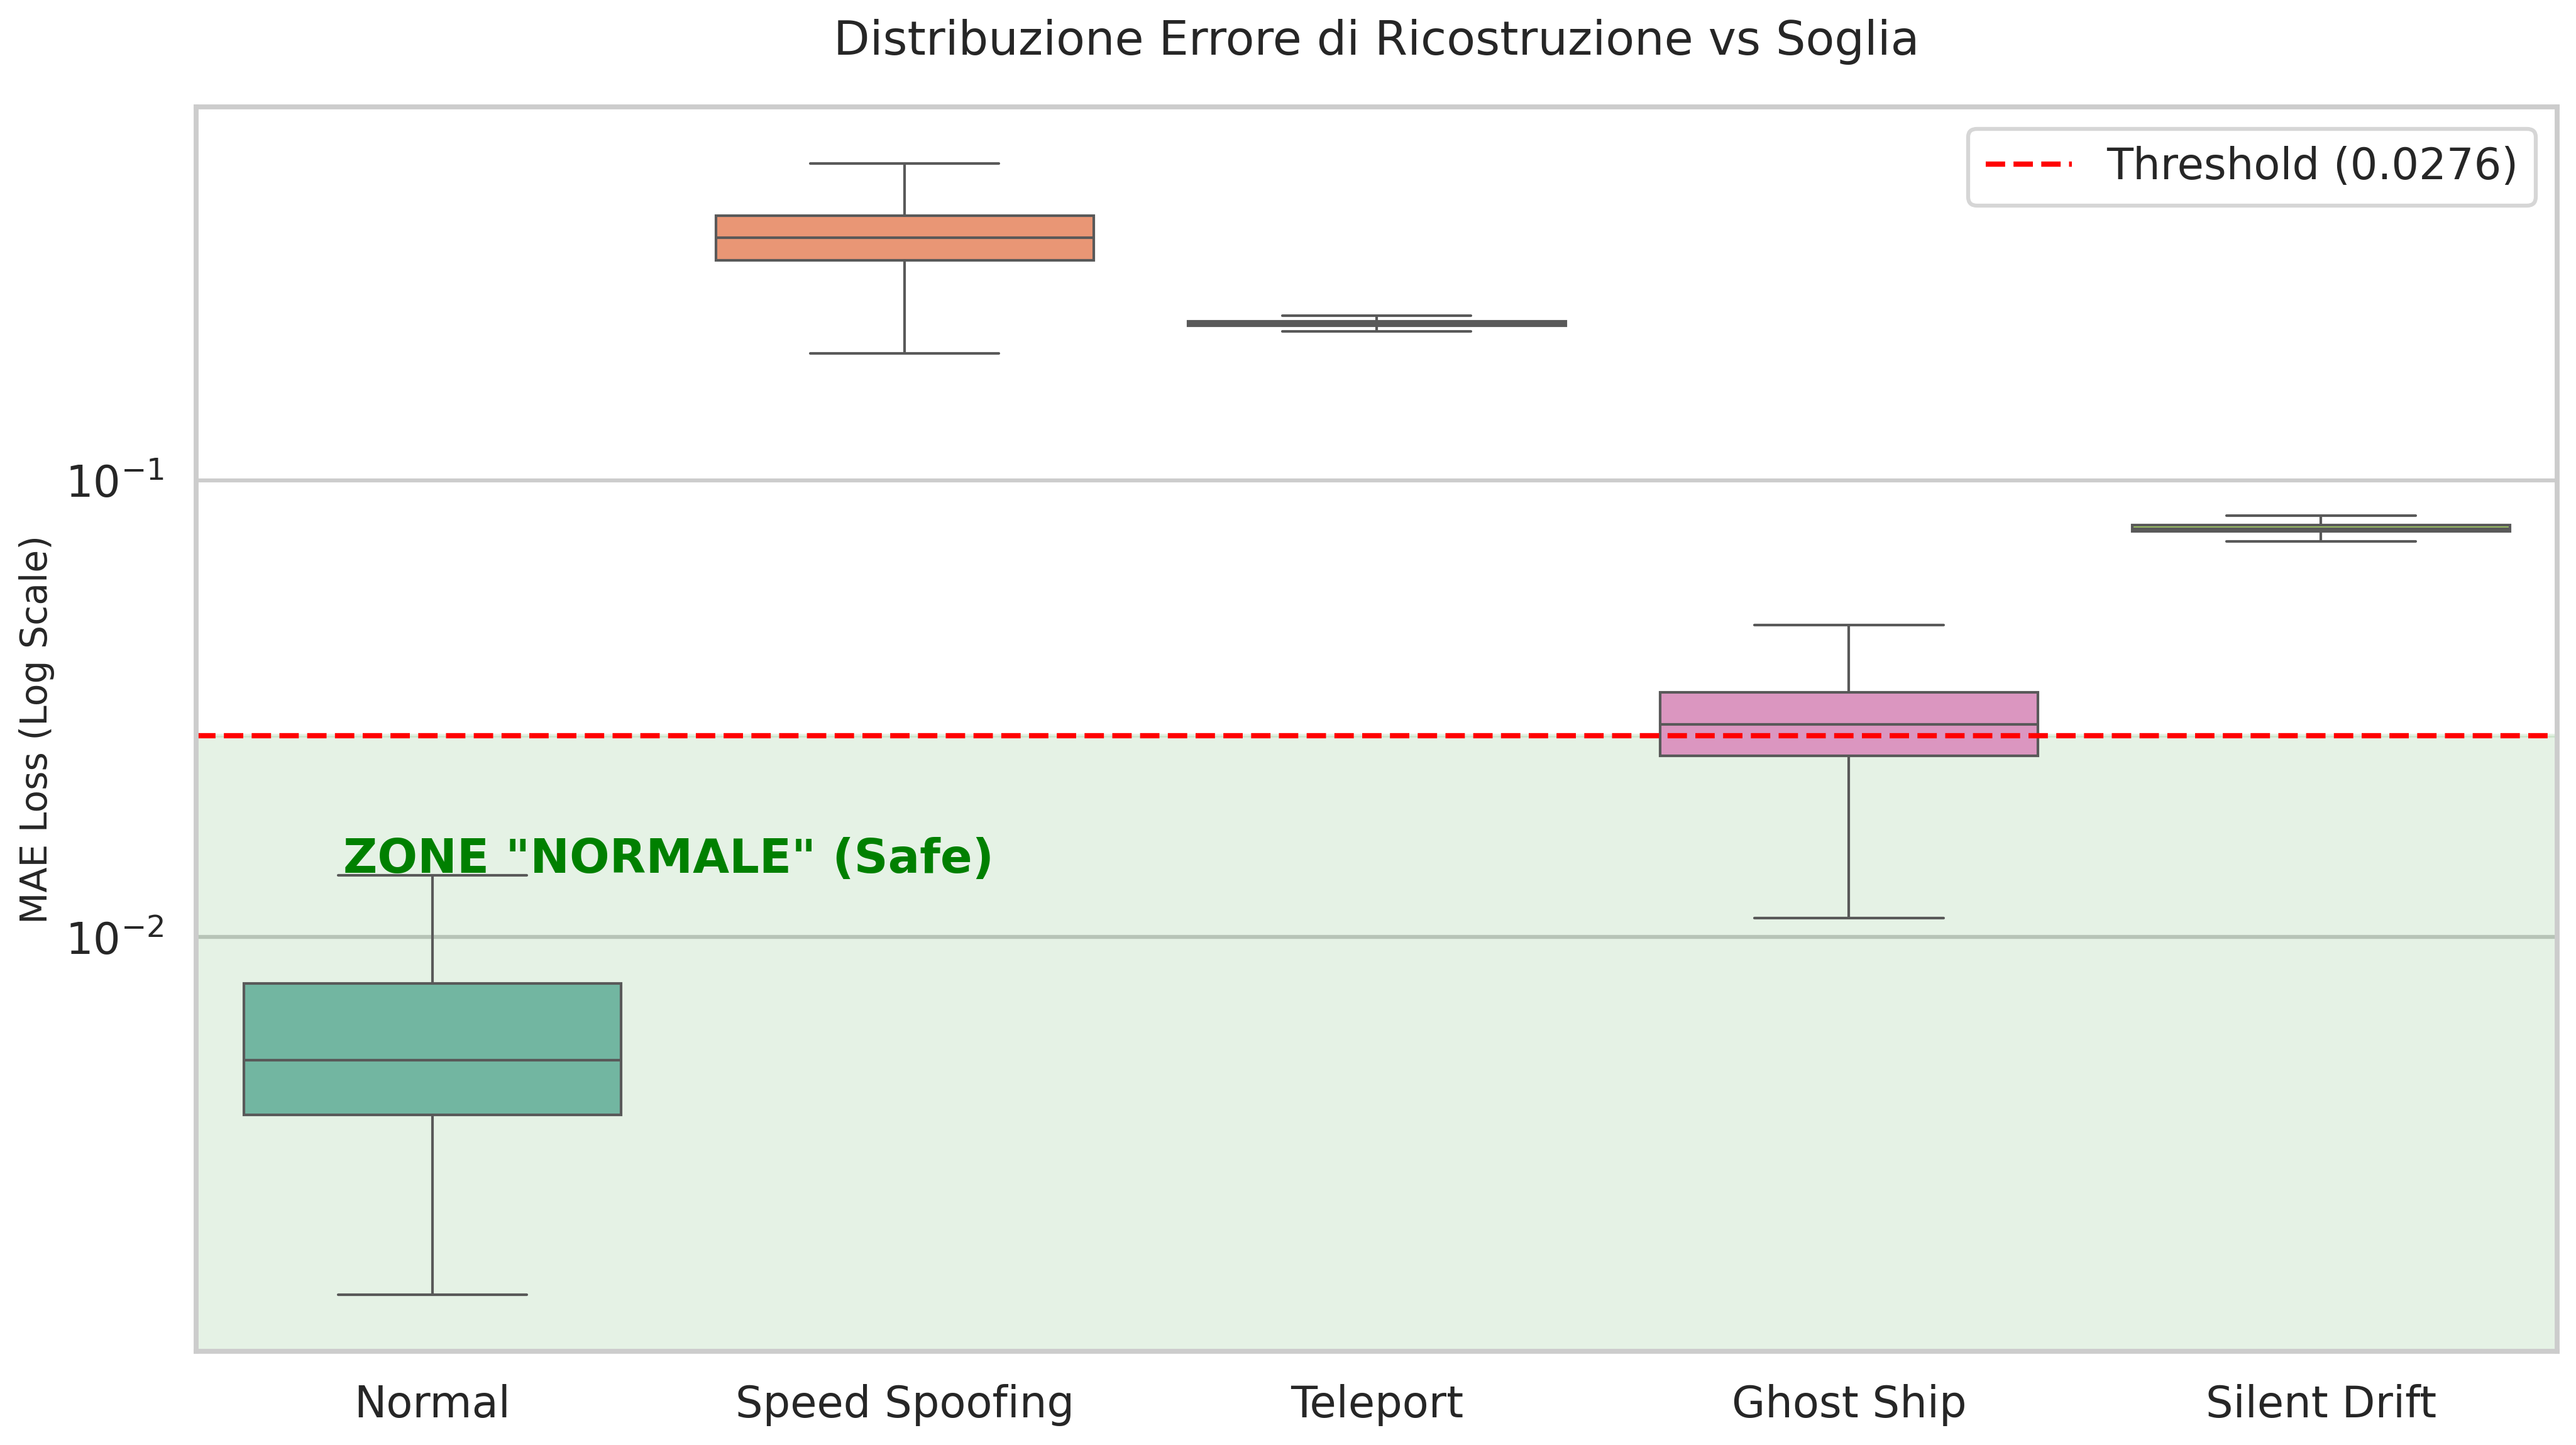

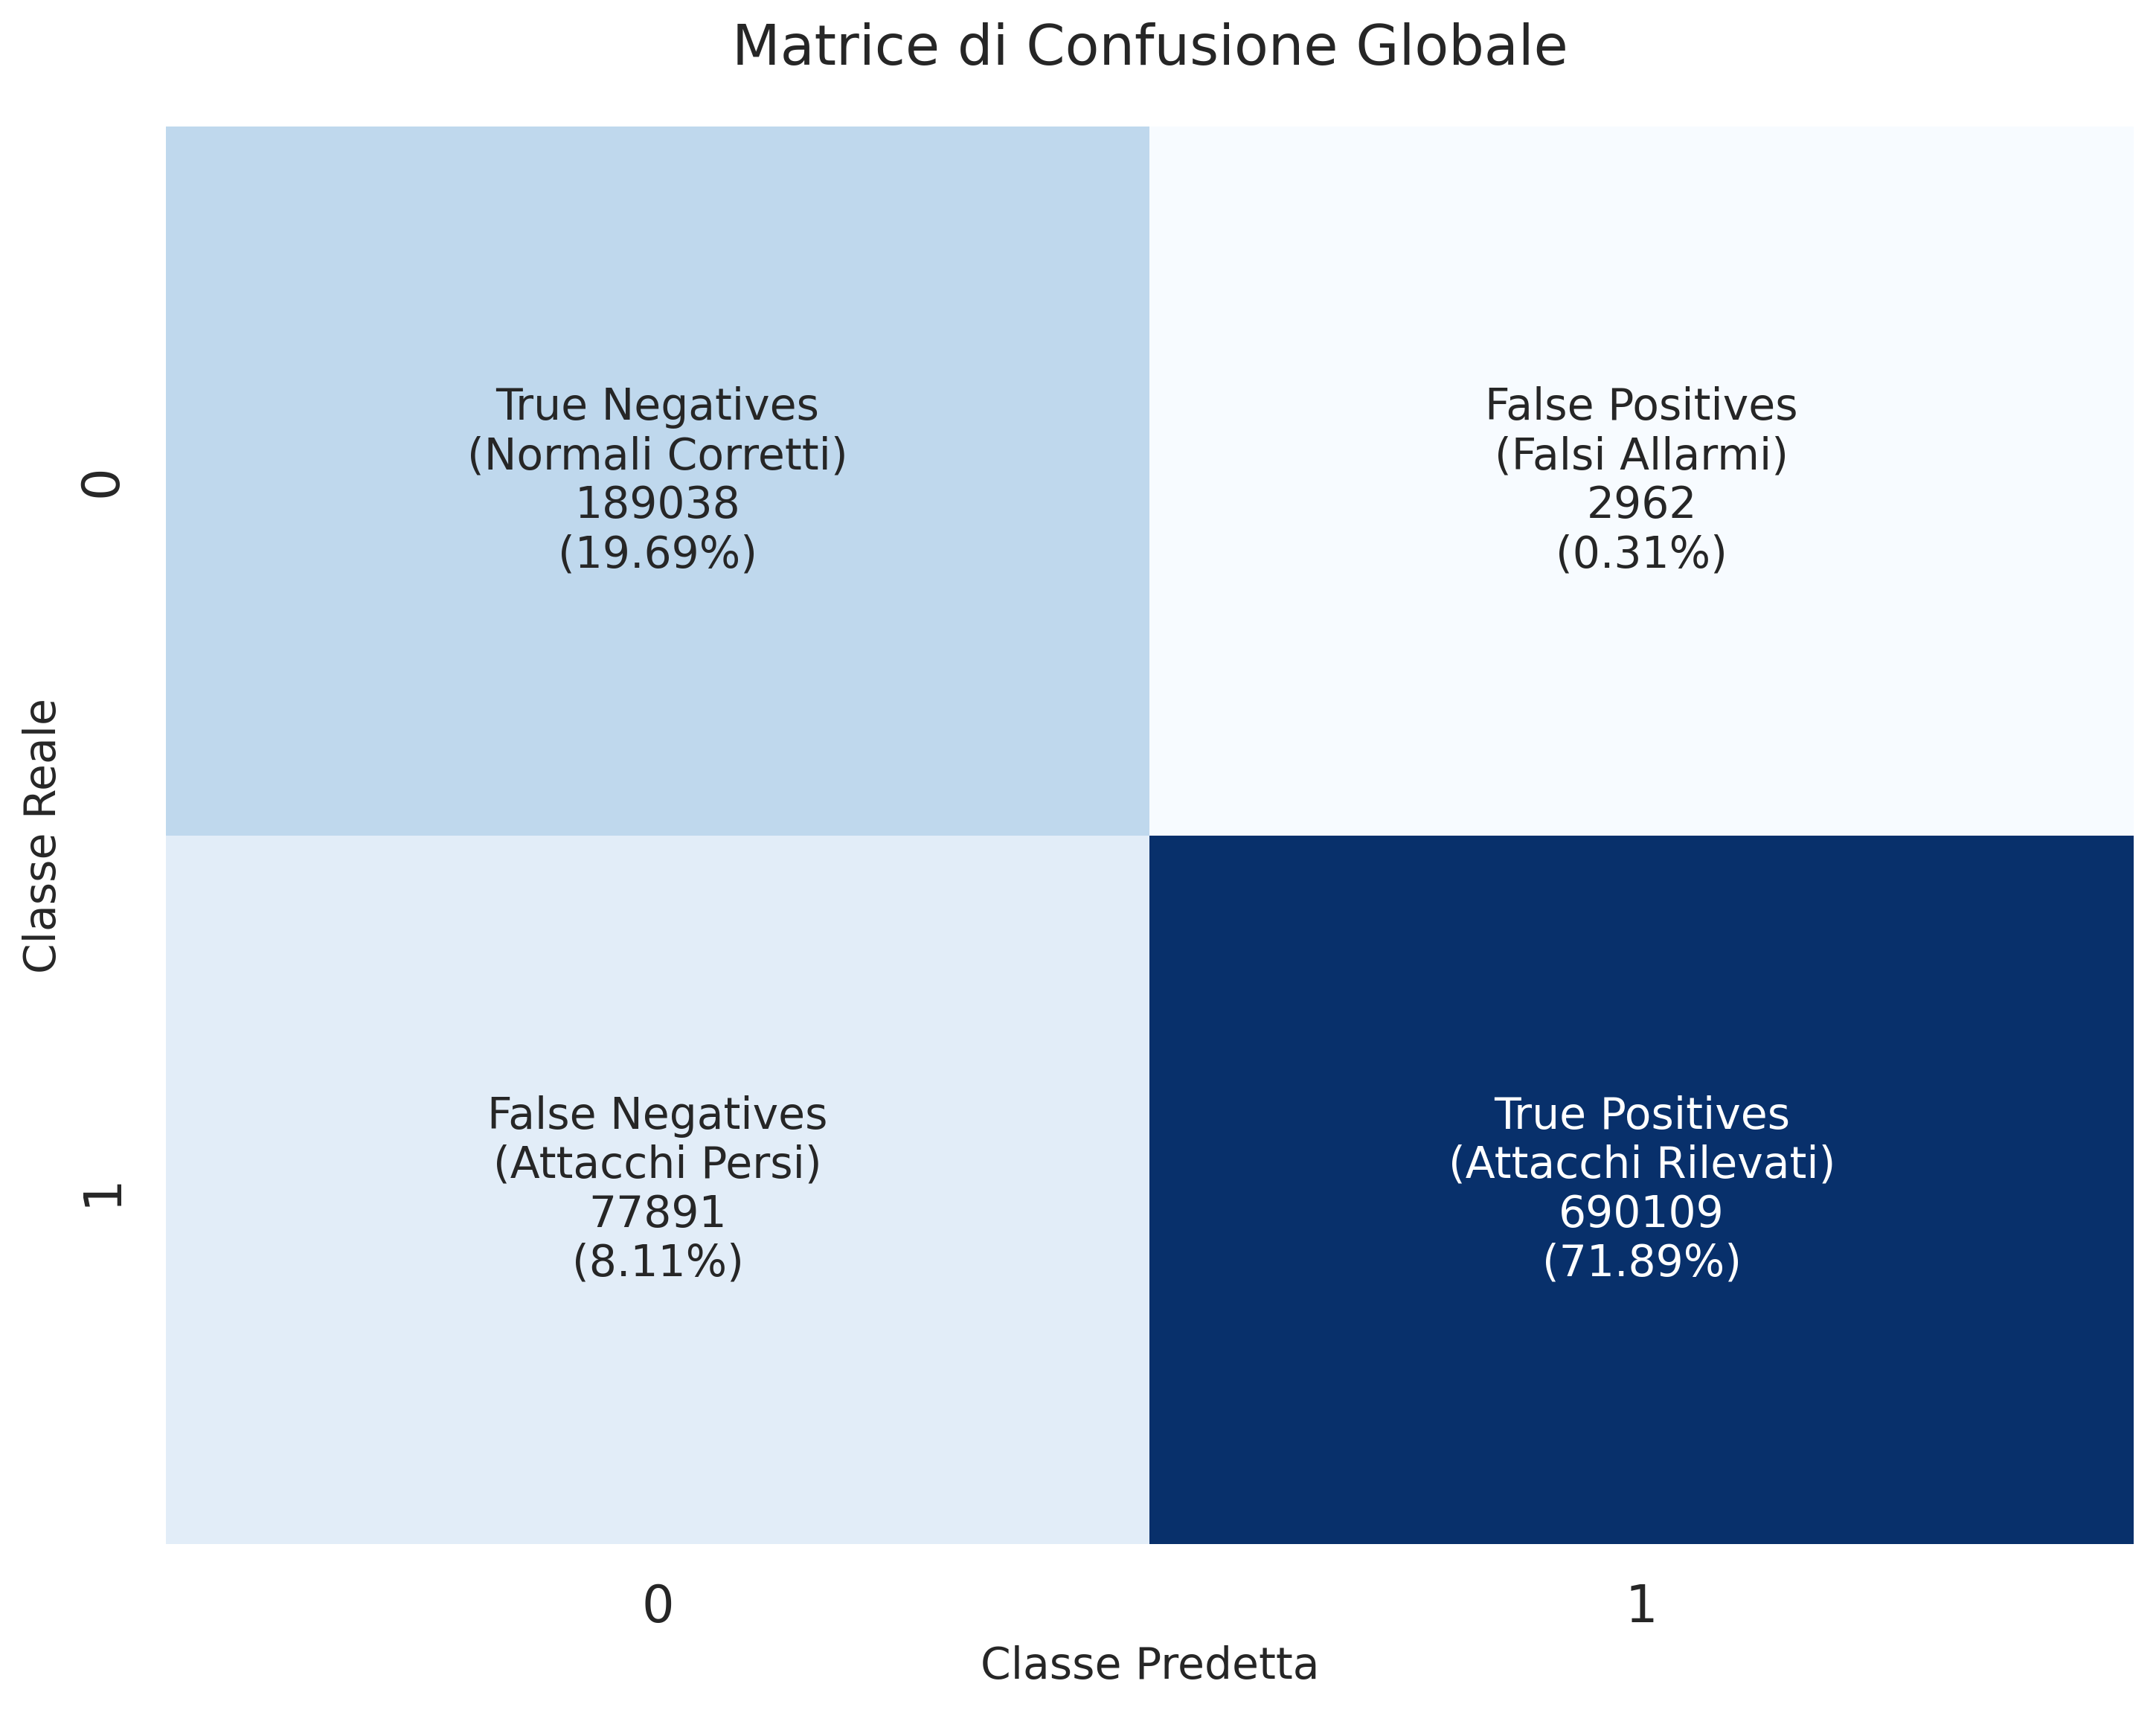


Tabella riassuntiva
| Scenario         |   Campioni Totali |   Rilevati come Attacco | Performance (%)      | Note                  |
|:-----------------|------------------:|------------------------:|:---------------------|:----------------------|
| Traffico Normale |            192000 |                    2962 | 98.46% (Specificità) | Falsi Positivi: 1.54% |
| Speed Spoofing   |            192000 |                  192000 | 100.00% (Recall)     | Rilevamento Critico   |
| Teleport         |            192000 |                  192000 | 100.00% (Recall)     | Rilevamento Critico   |
| Ghost Ship       |            192000 |                  114109 | 59.43% (Recall)      | Rilevamento Critico   |
| Silent Drift     |            192000 |                  192000 | 100.00% (Recall)     | Rilevamento Critico   |


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Preparazione Dati per Visualizzazioni
# Mappiamo i codici numerici ai nomi leggibili
attack_map = {0: 'Normal', 1: 'Speed Spoofing', 2: 'Teleport', 3: 'Ghost Ship', 4: 'Silent Drift'}
df_res = pd.DataFrame({
    'MAE': mae_loss,
    'Predicted': y_pred,
    'Actual': y_true,
    'Attack_Type_Code': attack_types
})
df_res['Scenario'] = df_res['Attack_Type_Code'].map(attack_map)

sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# Performance di Rilevamento
# Calcolo percentuali
detection_stats = df_res.groupby('Scenario').apply(lambda x: (x['Predicted'] == 1).sum() / len(x) * 100).reset_index(name='Detection_Rate')
# Rimuoviamo 'Normal' da questo grafico (che è Falsi Positivi) per focalizzarci sugli attacchi
attack_stats = detection_stats[detection_stats['Scenario'] != 'Normal'].copy()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Scenario', y='Detection_Rate', data=attack_stats, palette='viridis', hue='Scenario', legend=False)

# Annotazioni precise sopra le barre
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=14, fontweight='bold', xytext=(0, 5), textcoords='offset points')

plt.ylim(0, 115)
plt.title('Efficacia del Rilevamento LNN su 1M di Campioni', pad=20, fontsize=18)
plt.ylabel('Detection Rate (%)', fontsize=14)
plt.xlabel('')
plt.axhline(100, color='grey', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Analisi margini di sicurezza
# Per mostrare quanto è distante l'attacco dalla soglia
plt.figure(figsize=(14, 8))

ax = sns.boxplot(x='Scenario', y='MAE', data=df_res, palette='Set2', showfliers=False, hue='Scenario', legend=False)
plt.yscale('log') 

# Linea di Soglia
plt.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD:.4f})')

plt.title('Distribuzione Errore di Ricostruzione vs Soglia', fontsize=18, pad=20)
plt.ylabel('MAE Loss (Log Scale)', fontsize=14)
plt.xlabel('')
plt.legend(loc='upper right')

# Zona di Sicurezza
plt.axhspan(0, THRESHOLD, color='green', alpha=0.1)
plt.text(0.5, THRESHOLD/2, 'ZONE "NORMALE" (Safe)', color='green', fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

# Matrice di Confusione Globale
# Calcolo TP, TN, FP, FN globali
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Creiamo etichette personalizzate con i conteggi assoluti e percentuali
group_names = ['True Negatives\n(Normali Corretti)', 'False Positives\n(Falsi Allarmi)', 
               'False Negatives\n(Attacchi Persi)', 'True Positives\n(Attacchi Rilevati)']
group_counts = [f"{value:0.0f}" for value in [tn, fp, fn, tp]]
group_percentages = [f"{value:.2%}" for value in [tn/sum([tn,fp,fn,tp]), fp/sum([tn,fp,fn,tp]), fn/sum([tn,fp,fn,tp]), tp/sum([tn,fp,fn,tp])]]

labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10, 8))
sns.heatmap([[tn, fp], [fn, tp]], annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Matrice di Confusione Globale', fontsize=18, pad=20)
plt.ylabel('Classe Reale', fontsize=14)
plt.xlabel('Classe Predetta', fontsize=14)
plt.tight_layout()
plt.show()

# Tabella Riassuntiva
# Calcoliamo metriche dettagliate per ogni classe
summary_data = []

# Statistiche Normali
norm_mask = df_res['Scenario'] == 'Normal'
fp_count = (df_res[norm_mask]['Predicted'] == 1).sum()
tn_count = (df_res[norm_mask]['Predicted'] == 0).sum()
total_norm = len(df_res[norm_mask])
fpr = (fp_count / total_norm) * 100

summary_data.append({
    'Scenario': 'Traffico Normale',
    'Campioni Totali': total_norm,
    'Rilevati come Attacco': fp_count,
    'Performance (%)': f"{100-fpr:.2f}% (Specificità)",
    'Note': f"Falsi Positivi: {fpr:.2f}%"
})

# Statistiche Attacchi
for att in ['Speed Spoofing', 'Teleport', 'Ghost Ship', 'Silent Drift']:
    att_mask = df_res['Scenario'] == att
    tp_count = (df_res[att_mask]['Predicted'] == 1).sum()
    total_att = len(df_res[att_mask])
    recall = (tp_count / total_att) * 100
    
    summary_data.append({
        'Scenario': att,
        'Campioni Totali': total_att,
        'Rilevati come Attacco': tp_count,
        'Performance (%)': f"{recall:.2f}% (Recall)",
        'Note': "Rilevamento Critico"
    })

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("Tabella riassuntiva")
print("="*80)
print(df_summary.to_markdown(index=False))